# Deep Learning

We will build an end-to-end deep learning pipeline, from the initial visualization to evaluating a trained model.

We will be using the [PyTorch](https://pytorch.org/) deep learning library. If you have an NVIDIA GPU, you can take advantage of CUDA hardware acceleration by following instructions in the PyTorch learning library. The hardware acceleration features may improve your training times by 10x or more -- they are worth taking the time to set up.

That said, you should ensure that your code does not require CUDA: our grading machines do not have CUDA installed. 

Also, for this homework, the autograder time limit has been increased to six minutes.

In [1]:
import os
from testing.testing import test
import string
import time
import tarfile
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
# %matplotlib inline


if not os.environ.get("DISABLE_TESTING", False):
    %matplotlib inline

matplotlib.use("svg")
plt.style.use("ggplot")

import torch
from torch.utils import data

D:\python1\lib\site-packages\ipykernel_launcher.py:16: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "D:\python1\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "D:\python1\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "D:\python1\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "D:\python1\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "D:\python1\lib\site-packages\ipykernel\kernelapp.py", line 486, in start
    self.io_loop.start()
  File "D:\python1\lib\site-packages\tornado\platform\asyncio.py", line 127, in start
    self.asyncio_loop

## Oxford-IIIT Pet Dataset

We will be using the Oxford-IIIT Pet Dataset, which contains about 8000 images of cats and dogs.

Before we get to using the neural networks, as you are probably used to by now, we must fetch and process the data. For this assignment, you will be using the Oxford-IIIT pet dataset. The original dataset is [here](http://www.robots.ox.ac.uk/~vgg/data/pets/).

Run the below cell to download the images from our mirror. This is identical to the dataset but is hosted on a server in CMU (which should improve download speeds).

In [2]:
from pathlib import Path
import urllib.request

DOWNLOAD_PATH = Path("images.tar.gz")
UNPACKED_PATH = Path("images")

def get_dataset_test(get_dataset):
    get_dataset()
    test.true(UNPACKED_PATH.exists())

@test
def get_dataset():
    if UNPACKED_PATH.exists():
        return

    if not DOWNLOAD_PATH.exists():
        print("Downloading")
        urllib.request.urlretrieve("https://loci.cs.cmu.edu/pds/images.tar.gz", DOWNLOAD_PATH)
    
    print("Unpacking")
    with tarfile.open(DOWNLOAD_PATH) as t:
        t.extractall()
    
    print("Done!")

### TESTING get_dataset: PASSED 1/1
###



Our preprocessing pipeline looks like this:

1. Read from `.tar` file
2. Canonicalize the image
3. Prepare a separate train and test PyTorch `Dataset` from the array.

We provide you some code that reads the files from the dataset. Run it to view a cat image and a dog image.

### TESTING PetImages: PASSED 0/0
###



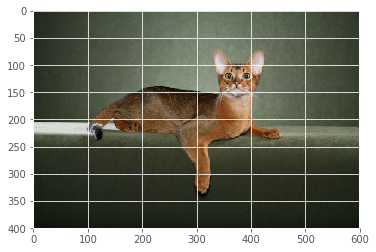

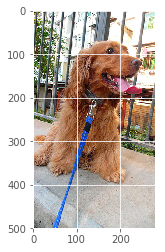

In [3]:
from PIL import Image

def PetImages_test(PetImages):
    pi = PetImages()
    plt.figure()
    plt.imshow(np.asarray(pi["Abyssinian_1.jpg"]))
    plt.figure()
    plt.imshow(np.asarray(pi["english_cocker_spaniel_198.jpg"]))

@test
class PetImages(object):
    def __init__(self, path=UNPACKED_PATH):
        self.path = Path(path)

    def __getitem__(self, fn):
        return Image.open(self.path / fn)

    def __iterate_orig(self):
        for m in self.path.iterdir():
            if m.suffix == ".jpg":
                if m.stem[0] in "abcdef":
                    continue
                yield (m.stem, m)

    def iterate(self):
        for m_stem, m in sorted(self.__iterate_orig(), key=lambda x: x[0][::-1]):
            yield m_stem, Image.open(m)

### Canonicalizing Images

The images have different shapes and sizes; we need to standardize them to a consistent size and shape before we can further use them. (Many computer vision datasets, such as ImageNet, provide images in a canonical form.)

Here we will crop all images to a square [aspect ratio](https://en.wikipedia.org/wiki/Aspect_ratio_(image)), and then resize them to a given size. The default value is $64 \times64$ pixels.

Specification:
1. Crop the image to be a square by reducing one dimension to be the same size as the other. You should center your cropping as much as possible (e.g. crop the same number of pixels from the left as from the right). If you must crop an odd number of pixels, then crop an extra pixel from the right or from the bottom.
2. Convert the image to an "RGB" image (there are some greyscale and/or transparent images in the dataset).
2. Resize the image to be `size` by `size` pixels. You should use the `Image.ANTIALIAS` filter for the resample parameter -- this improves the quality of the downsized image.

Hints:
1. The PIL documentation is [here](https://pillow.readthedocs.io/en/stable/reference/Image.html).

### TESTING canonicalize: PASSED 0/0
###



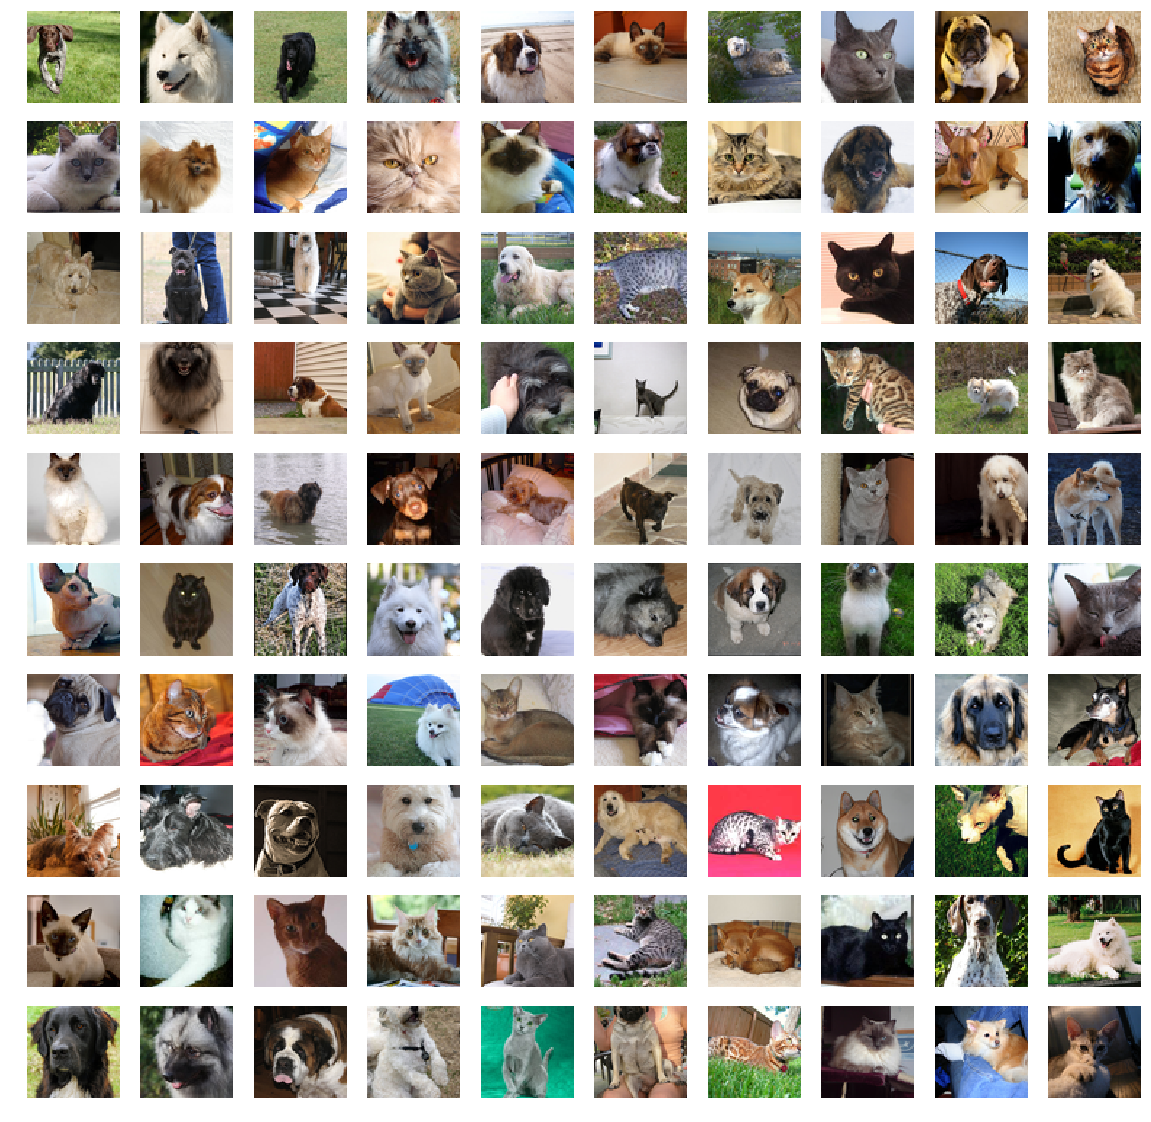

In [4]:
def canonicalize_test(canonicalize):
    pi = PetImages()
    plt.figure(figsize=(20,20))
    for i,p in zip(range(100), pi.iterate()):
        plt.subplot(10,10,i+1)
        plt.axis('off')
        plt.imshow(np.asarray(canonicalize(p[1])))

@test
def canonicalize(im, size=64):
    """ Crops and scales a given image into its canonical form. 
        args: 
            im : PIL Image -- image object to be cropped and scaled
        kwargs:
            size: int -- the size of the final square image
        returns: PIL Image -- cropped and scaled image object
    """
    w, h = im.size
    if w > h:
        new_w = h
        left = int((w - new_w)/2)
        right=(w-new_w)%2
#         right = left + new_w
        crops = im.crop((left, 0, w-left-right, h))
    elif h > w:
        new_h = w
        top = int((h - new_h)/2)
        bottom = (h-new_h)%2
#         bottom = top + new_h
        crops = im.crop((0, top, w, h-top-bottom))
    else:
        crops = im
    
    image = crops.resize((size, size), Image.ANTIALIAS)
    image = image.convert("RGB")
    return image
    pass
    pass
















































### Preparing data for PyTorch

Now that we have the images and a canonicalization function, we can prepare the dataset for use with PyTorch. While we can train the model from Numpy arrays, it is generally more efficient to use the data preprocessing pipelines provided by your deep learning library.

In this case, our images will take about 600MB to store in memory, so we can load the canonicalized images and keep them in memory during training. (The original images are too large to be loaded into memory.)

Use `PetImages` and `canonicalize` to implement `PetDataset`.

Specification:

 1. `self.data` should be a `np.ndarray` of type `np.float32`, with image values scaled from [0, 255] down to the range [0, 1]. The images should be transposed so the dimensions of `self.data` are (Example, Channel, Height, Width).
 2. `self.labels` should be a `np.ndarray` of type `np.bool` which is `True` when the image is a cat and `False` otherwise. The shape should be (Example, 1).

Hints:

 - Construct the data array as a `np.ndarray` and then pass it to `torch.as_tensor` to convert it to a PyTorch tensor.
 - Read the previous test cases for an example of how to use `PetImages`.
 - If the filename starts with an uppercase letter, the image is that of a cat.
 - The input axis order is (Height, Width, Channel).

In [5]:
import re
def PetDataset_load_test(PetDataset_load):
    pi = PetImages()
    ds = PetDataset_load(pi)
    #ds = PetDataset.load("PetDataset-64.npz")

    test.equal(ds.data.shape, (5790, 3, 64, 64))
    test.equal(ds.labels.shape, (5790, 1))
    # Check conversion from [0, 255] to [0, 1]:
    test.equal(ds.data.max(), 1.0)
    test.equal(ds.data.min(), 0.0)

    # Functionality test:
    ex = ds[0]
    test.equal(type(ex), dict)
    test.equal(type(ex["label"]), np.ndarray)
    test.equal(ex["image"].shape, (3, 64, 64))
    # If this is slightly different, check that you set the antialias option on resizing:
    test.equal(ex["image"][:,12,23].tolist(), [0.6392157077789307, 0.545098066329956, 0.48235294222831726])

    # Loading and converting the images is slow. We'll save the generated dataset here.
    ds.save("PetDataset-64.npz")


class PetDataset(torch.utils.data.Dataset):
    """Pet images dataset."""
    
    @staticmethod
    def from_images(petimages : PetImages, size : int=64):
        """
        args:
            petimages : PetImages -- The PetImages object containing the images.
        kwargs:
            size : int -- the size of the canonicalized images.
        """
        # You should load all images into memory here -- don't keep a reference to petimages after this function.
        # (We want to avoid reading data from disk in our training loop because that is very slow.)

        d=[]
        l=[]
        for p in petimages.iterate():
            data1=np.asarray(canonicalize(p[1], size=size)).astype(np.float64)
            data1 = data1/255
            data1 = data1.transpose((2, 0, 1))
            d.append(data1)
            if re.match("[A-Z]", p[0])==None:
                l.append([False])
            else:
                l.append([True])
            
        data = np.array(d, dtype = np.float32)
        labels = np.array(l)
#         labels = labels.float()
        return PetDataset(data, labels)

    
    def __init__(self, data, labels):
        # Don't change the constructor
        self.data = data
        self.labels = labels

    def __len__(self):
        """ Return the number of images in the dataset.
        """
        return len(self.labels)

    def __getitem__(self, idx):
        """ Return the element corresponding to idx.
        
        args:
            idx : int -- the index of the sample to return
            
        returns: Dict -- A dictionary with two elements; "label" and "image". "label" has the associated label
            and "image" is a (size, size, 3)
        """
        # Convert it to a regular python int.
        if torch.is_tensor(idx):
            idx = idx.tolist()

        d={}
        label = self.labels[idx]
        image = self.data[idx]
        d["label"] = label
        d["image"] = image
        return d
    
    def save(self, path : Path):
        """ Save the dataset.
        """
        np.savez(path, data=self.data, labels=self.labels)

    @staticmethod
    def load(path : Path):
        l = np.load(path)
        return PetDataset(l["data"], l["labels"])

@test
def PetDataset_load(pi):
    return PetDataset.from_images(pi)

### TESTING PetDataset_load: PASSED 8/8
###



### Train / Test split

We've gone to all this effort to write a PyTorch `Dataset` object, and its about to pay off. Use `torch.utils.data.random_split` to split the dataset into a train and test set. The train set should contain `train_count` randomly selected examples, and the test set should contain the rest.

Hint: This should take _one_ line of code.

In [6]:
def split_test(split):
    pet = PetDataset.load("PetDataset-64.npz")
    r = split(pet)
    test.equal(len(r), 2)
    test.equal(type(r[0]), torch.utils.data.dataset.Subset)
    test.equal(type(r[1]), torch.utils.data.dataset.Subset)
    test.equal(len(r[0]), 5000)
    test.equal(len(r[1]), len(pet) - 5000)    
    
@test
def split(pet : PetDataset, train_count=5000):
    """ Split pet into train and test sets.
    
    args:
        pet : PetDataset -- the PetDataset instance to split.

    kwargs:
        train_count: The number of elements in the training set. The remainder should be in the test set.
    
    return: List[Dataset] -- the list of [train, test] datasets.
    """
#     torch.manual_seed(0)
    split = torch.utils.data.random_split(pet, [train_count, len(pet)-train_count] )
    return split
    pass

### TESTING split: PASSED 5/5
###



## Deep Learning

Our dataset is ready! Now we can move on to the actual deep learning. We begin by defining a model, preparing a training loop, and training the model on the training set until it reaches some performance.

We give you a very simple starting model. You will want to come back to this and change it to improve model performance once you've written the training loop.

Specification:

 - `PetModel` must be an `nn.Module` that accepts tensors with input dimensions `(N, 3, 64, 64)`, where `N` is the number of examples in a batch.
 - It must produce an output of shape `(N, 1)` (not `(N,)`; the trailing dimension is important)
 - The output values must be in range `[0, 1]`.
 - The output should predict the cat-likeness of the image. That is, `output[k,0] > 0.5` if the model predicts the image has a cat, otherwise it predicts a dog.
 - Your model is limited to 50,000 parameters.  
 - You can change the internal structure however you like. 

Hints:

 - tinker around with the network architecture a little and you should be able to meet the performance requirements
   - look at the [torch.nn](https://pytorch.org/docs/stable/nn.html) documentation for layers you can use
   - look at the [structure of the VGG-16 network](https://arxiv.org/abs/1409.1556) for inspiration
 - having more parameters is not necessary to improve performance; we can pass the performance requirement with < 15,000 parameters

In [7]:
from torch import nn

class PetModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.relu1 = nn.ReLU()
        self.fc1   = nn.Linear(18000, 1)
#         self.fc1   = nn.Linear(12288, 1)
#         self.drt   = nn.Dropout(p=0.1)
        self.sigm1 = nn.Sigmoid()
    
    def forward(self, X, debug=False):
        if debug: print(f"Input Shape: {X.shape}")

        X = self.relu1(self.conv1(X))
        if debug: print(f"Conv1 Shape: {X.shape}")

        X = X.view(X.size(0), -1) # Flatten the shape
        if debug: print(f"Flattened Shape: {X.shape}")

#         X = self.drt(self.fc1(X))
#         if debug: print(f"After Dropout Shape: {X.shape}")
            
        X = self.sigm1(self.fc1(X))
        if debug: print(f"Output Shape: {X.shape}")

        return X

def count_parameters(model):
    # Count all trainable parameters,
    # from https://discuss.pytorch.org/t/how-do-i-check-the-number-of-parameters-of-a-model/4325/9
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def petmodel_test(petmodel):
    # Check that the dimensions work out in your PetModel class.
    # We try two different batch sizes to ensure that you don't accidentally hard-code the
    # number of parameters.
    pm = petmodel()
    X = torch.zeros(5, 3, 64, 64)
    X = pm(X, debug=True)
    test.equal(X.shape, (5, 1))

    X = torch.zeros(61, 3, 64, 64)
    X = pm(X, debug=True)
    test.equal(X.shape, (61, 1))
    
    num_param = count_parameters(pm)
    print(f"Model has {num_param} params, maximum allowed 50000")
    test.true(num_param < 50000)
    
@test
def petmodel():
    return PetModel()

Input Shape: torch.Size([5, 3, 64, 64])
Conv1 Shape: torch.Size([5, 5, 60, 60])
Flattened Shape: torch.Size([5, 18000])
Output Shape: torch.Size([5, 1])
Input Shape: torch.Size([61, 3, 64, 64])
Conv1 Shape: torch.Size([61, 5, 60, 60])
Flattened Shape: torch.Size([61, 18000])
Output Shape: torch.Size([61, 1])
Model has 18381 params, maximum allowed 50000
### TESTING petmodel: PASSED 3/3
###



Now we write the training loop. We've provided you with most of the code, only leaving out the crucial section. You need to:

  - Use a `DataLoader` to load the data in batches
  - For each epoch, loop over all training batches performing:
    - the forward pass,
    - the backward pass,
    - update model weights using an optimizer

You are free to tweak hyperparameters as you see fit.

Specifications:

  - Your training loop code should train the `PetModel` you defined above to predict if an input image has a cat in it.
  - The accuracy of your model should be at least 69% on the training set and at least 65% on the test set.
  - Your training should be batched; the input should be processed no more than `batch_size` units at a time (We need this to limit the memory use of your model on the grading machines.)
  - Your trained model should _consistently_ be able to meet the performance requirements. You should run the cell at least three times before submitting to make sure.
  - Your training loop should run for no more than 100 epochs.

Hint:

- The loss function should be a form of cross-entropy loss that works with binary classification
- The `Adam` optimizer is a good choice; you may need to experiment with the learning rate
- The error measure we care about is accuracy; this has been implemented for you in `test_model`.
- Read the implementation of `test_model`; it may help you implement your training loop.

In [8]:
import torch.optim as optim

def training_loop_test(training_loop):
    pet = PetDataset.load("PetDataset-64.npz")
    train_data, test_data = tuple(split(pet))
    
    model = PetModel()
    
    training_loop(model, train_data)
    
    train_acc = test_model(model, train_data)
    test.true(train_acc >= 0.69) 
    print(f"Train accuracy: {train_acc}")
    
    test_acc = test_model(model, test_data)
    test.true(test_acc >= 0.65) 
    print(f"Test accuracy: {test_acc}")
    
    torch.save(model.state_dict(), "PetModel.pt")    

def test_model(model, test_data, batch_size=500):
    test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)
    num_correct = 0
    for data in test_dataloader:
        y_pred = model(data["image"])
        y_actual = data["label"].float()
        num_correct += (y_pred.round() == y_actual).sum()
    return num_correct.item() / len(test_data)

@test
def training_loop(model, train_dataset, epochs=30, batch_size=500):
    """ Train the model on data
    """
    dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    start_time = time.perf_counter()
    for epoch in range(epochs):
        # If you add the training loss to this variable, it will be printed for you
        epoch_loss = 0.0
        for i, data in enumerate(dataloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs = data['image']
            labels = data['label'].float()

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        

        epoch += 1
        if epoch % 5 == 0:
            curr_time = time.perf_counter() - start_time
            # Print [current_time / total_expected_time ], followed by the training loss and accuracy.
            print(f'[{curr_time:6.1f}/{curr_time/epoch*epochs:6.1f}] Epoch {epoch: <3d} loss: {epoch_loss / 5000} acc: {test_model(model, train_dataset)}')
    print("Done.")

[  26.3/ 157.6] Epoch 5   loss: 0.0 acc: 0.625
[  55.9/ 167.8] Epoch 10  loss: 0.0 acc: 0.711
[  82.5/ 164.9] Epoch 15  loss: 0.0 acc: 0.7486
[ 107.9/ 161.9] Epoch 20  loss: 0.0 acc: 0.7738
[ 133.2/ 159.9] Epoch 25  loss: 0.0 acc: 0.7926
[ 159.0/ 159.0] Epoch 30  loss: 0.0 acc: 0.8048
Done.
Train accuracy: 0.8048
Test accuracy: 0.6645569620253164
### TESTING training_loop: PASSED 2/2
###



In [16]:
# We use this function for the grader, don't remove it:
def grade_model_and_training():
    return training_loop, PetModel

Congratulations on having finished this assignment! As a bonus, lets visualize some animals and labels.

We display 100 images with the predicted label. The prediction is in green if it matches the actual label, and red otherwise.

### TESTING visualize_trained_model: PASSED 0/0
###



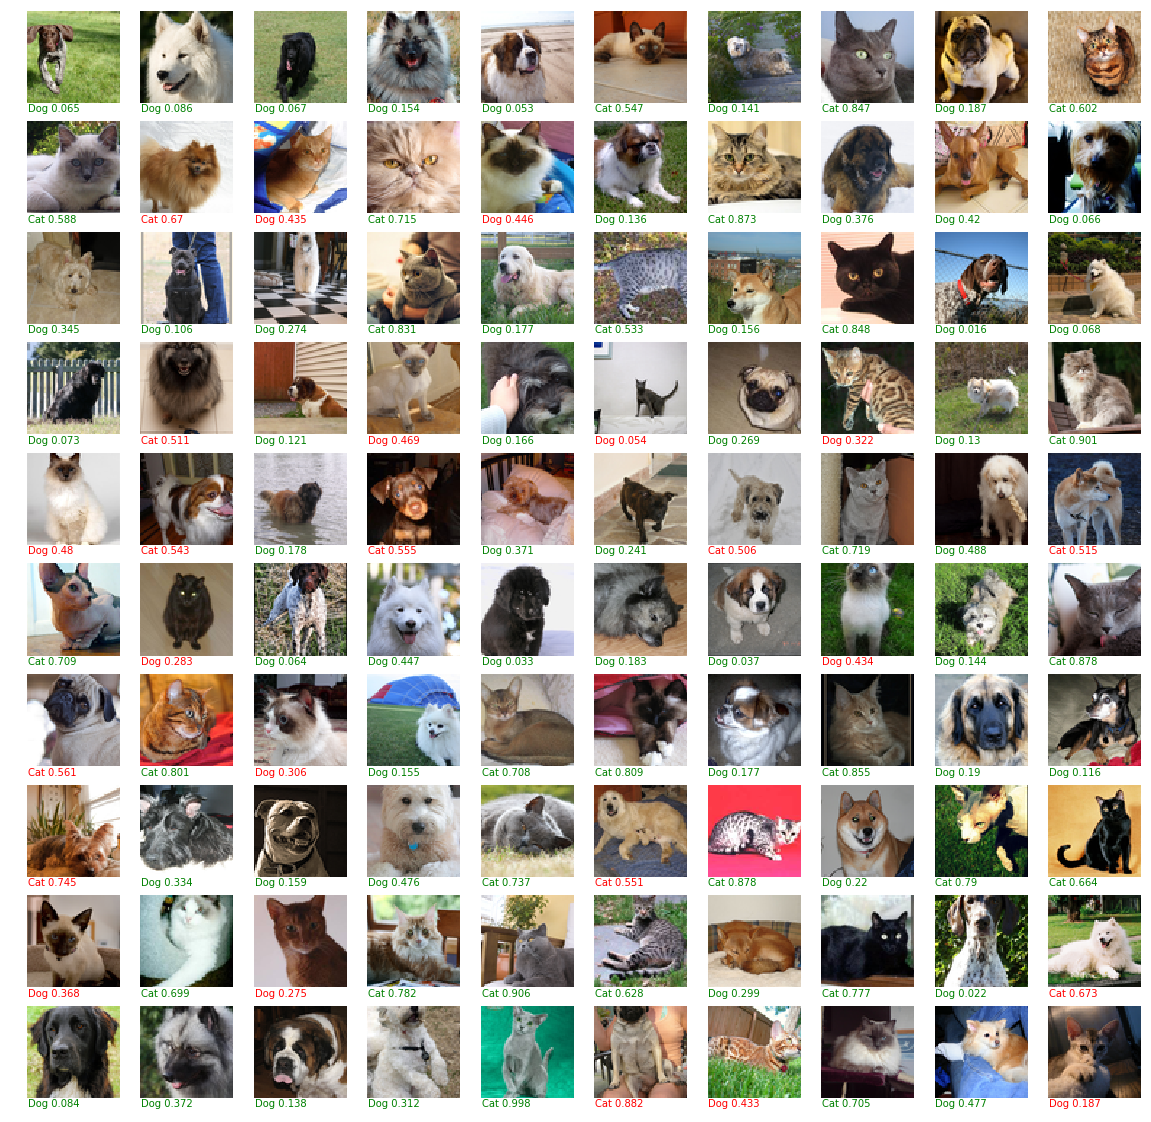

In [17]:
def visualize_trained_model_test(visualize_trained_model):
    pet = PetDataset.load("PetDataset-64.npz")
    model = PetModel()
    model.load_state_dict(torch.load("PetModel.pt"))
    visualize_trained_model(pet, model)

@test
def visualize_trained_model(pet, model):
    dataloader = torch.utils.data.DataLoader(pet, batch_size=100)
    data = next(iter(dataloader))
    pred = model(data["image"])

    plt.figure(figsize=(20,20))
    for i in range(100):
        plt.subplot(10,10,i+1)
        plt.axis('off')
        plt.imshow(data["image"][i,...].numpy().transpose([1, 2, 0]))
        color = {"color": "green" if pred[i].round() == data["label"][i] else "red" }
        plt.text(0, 70, ("Cat" if pred[i].round() else "Dog") + " " + str(round(pred[i].item(), 3)), color)